# A good data shuffle before training

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
plt.style.use('ggplot')

from architectures import *
from functions import *

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 960086350921652500
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7445515469
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4407598810075267835
physical_device_desc: "device: 0, name: Tesla M60, pci bus id: 0000:00:1e.0, compute capability: 5.2"
]


### 1.1 Load dataset

In [3]:
# Load test set (Third dataset)
test_images = np.load('processed_data/test_images.npy')
test_flows = np.load('processed_data/test_flows.npy')
test_targets = np.load('processed_data/test_images_targets.npy')

# Training data
with np.load('processed_data/shuffled_images.npz') as data:
    train_images = data['arr_0']

with np.load('processed_data/shuffled_flow.npz') as data:
    train_flows = data['arr_0']
    
with np.load('processed_data/shuffled_targets.npz') as data:
    train_targets = data['arr_0']
    
# Augmented training data
train_images_aug = np.load('processed_data/X_train_images_aug.npy')
train_flows_aug = np.load('processed_data/X_train_flows_aug.npy')
train_targets_aug = np.load('processed_data/Y_train_images_aug.npy')


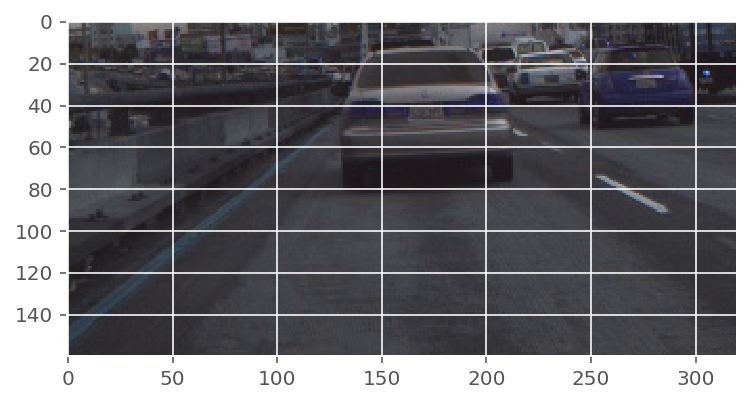

In [4]:
plt.imshow(train_images_aug[0])

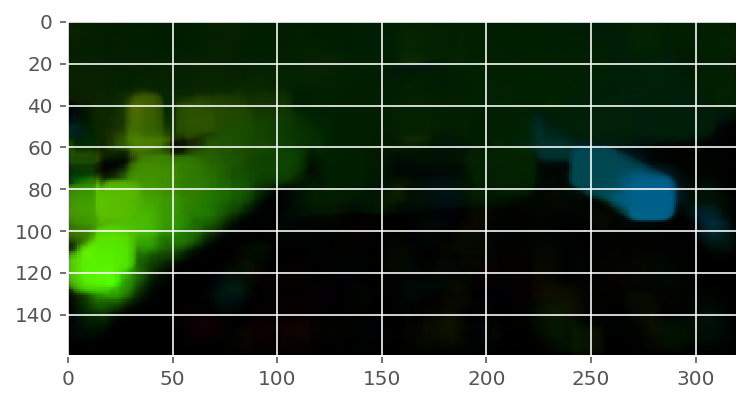

In [5]:
plt.imshow(train_flows_aug[0])

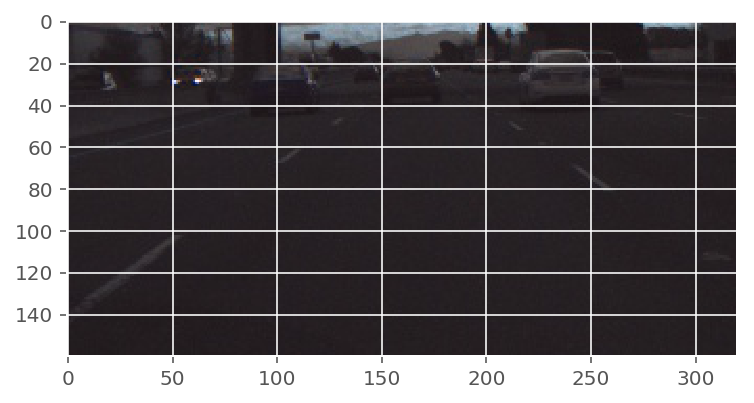

In [6]:
plt.imshow(train_images[0])

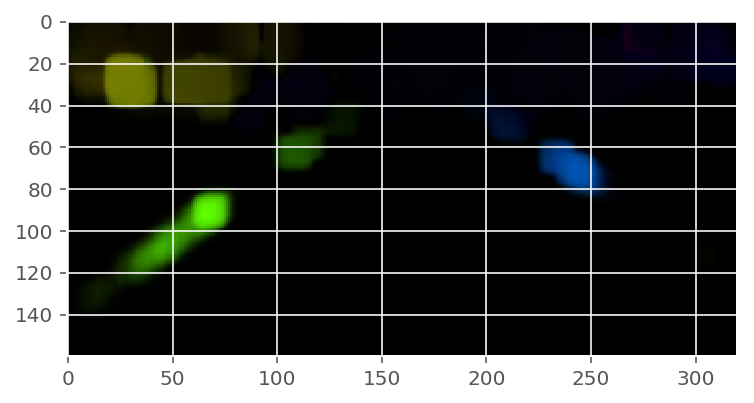

In [7]:
plt.imshow(train_flows[0])

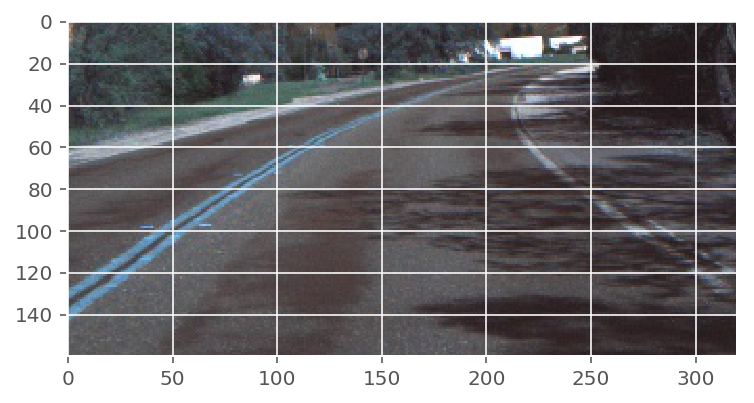

In [8]:
plt.imshow(test_images[0])

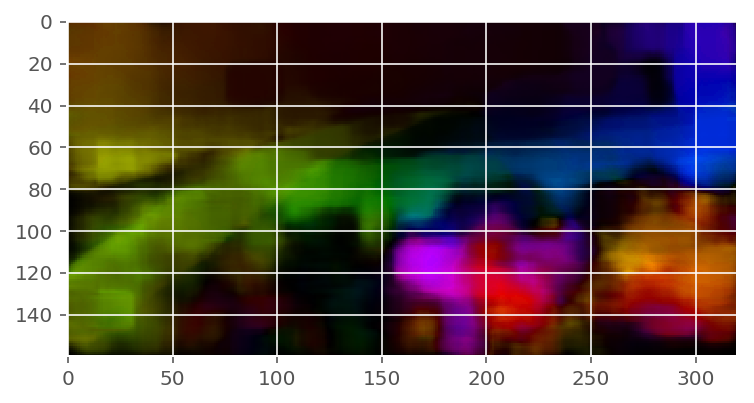

In [9]:
plt.imshow(test_flows[0])

### 1.2 Merge all datasets on a single dataset

In [4]:
images = np.concatenate((train_images, train_images_aug, test_images)) 
flows = np.concatenate((train_flows, train_flows_aug, test_flows))
targets = np.concatenate((train_targets, train_targets_aug, test_targets)).astype('float32') 

del train_images, train_images_aug, test_images, train_flows, train_flows_aug, test_flows

#### Note:
    Flows are also images from 0 to 255. So it can be normalized with the same lambda function.

In [11]:
print(np.max(flows))
print(np.min(flows))

255
0


### 1.3 Shuffle all examples - Preserve the ordered pairs - Create train/val/test partitions

In [4]:
def shuffle_data2(X_im, X_fl, Y, proportion = 0.6):
    # Generate a random selection of indexes
    indexes = random.sample(range(0, X_im.shape[0]), int(X_im.shape[0]*proportion))
    # Select desired examples for training (images)
    train_im = X_im[indexes]
    train_fl = X_fl[indexes]
    train_Y = Y[indexes].astype('float32')
    
    # Get indexes of non-chosen elements for data augmentation
    test_indexes = []
    for x in tqdm(range(0,X_im.shape[0])):
        if x not in indexes:
            test_indexes.append(x)
            
    # Select desired examples for training
    test_im = X_im[test_indexes]
    test_fl = X_fl[test_indexes]
    test_Y = Y[test_indexes].astype('float32')
        
    return train_im, train_fl, train_Y, test_im, test_fl, test_Y
    

### Generating partitions for training step1 and step2 - Saving all frames to disc

In [6]:
# Split the whole data set in 50% for pre-training and 50% for finetuning
train_im, train_fl, train_Y, train_im2, train_fl2, train_Y2 = shuffle_data2(images, flows, targets, proportion = 0.5)

del images, flows, targets

100%|██████████| 138171/138171 [02:53<00:00, 795.54it/s]


In [7]:
#np.save('shuffle_dataset/train_im.npy', train_im)
#np.save('shuffle_dataset/train_fl.npy', train_fl)
#np.save('shuffle_dataset/train_Y.npy', train_Y)

#np.save('shuffle_dataset/train_im2.npy', train_im2)
#np.save('shuffle_dataset/train_fl2.npy', train_fl2)
#np.save('shuffle_dataset/train_Y2.npy', train_Y2)

## Load pre-shuffled data for training step 1

In [9]:
# Load step1 data
train_im = np.load('shuffle_dataset/train_im.npy')
train_fl = np.load('shuffle_dataset/train_fl.npy')
train_Y = np.load('shuffle_dataset/train_Y.npy')

# Split the 50% train dataset and generate a validation partition of 30% # Training proportion = 0.7
train_im, train_fl, train_Y, val_im, val_fl, val_Y = shuffle_data2(train_im, train_fl, train_Y, proportion = 0.7)

100%|██████████| 69085/69085 [00:51<00:00, 1339.98it/s]


### Generating partitions for training step2 - Better to do it at the end, after deleting training1

### So far we have:

    - Train/val step1 (50%):     training split 70%:  train_im, train_fl, train_Y
                                 validation split 30%: val_im, val_fl, val_Y

    - Train/val step2 (50%):     training split 70%:  train_im2, train_fl2, train_Y2
                                 validation split 30%: val_im2, val_fl2, val_Y2  
                                 
    - Test set (20% of the 50%): test_im, test_fl, test_Y

## Part 2: Training Spatial baseline

In [6]:
spatial = baseline()

In [10]:
spatial_final, history = train_convnet2D(spatial, train_im, train_Y, 
                                         val_im, val_Y, epochs=20,
                                         model_name='spatial_checkpoint_shuffle.hdf5')

Train on 48359 samples, validate on 20726 samples
Epoch 1/20
48359/48359 [==============================] - 85s 2ms/step - loss: 0.0571 - val_loss: 0.0514

Epoch 00001: val_loss improved from inf to 0.05135, saving model to spatial_checkpoint_shuffle.hdf5
Epoch 2/20
48359/48359 [==============================] - 85s 2ms/step - loss: 0.0453 - val_loss: 0.0494

Epoch 00002: val_loss improved from 0.05135 to 0.04942, saving model to spatial_checkpoint_shuffle.hdf5
Epoch 3/20
48359/48359 [==============================] - 85s 2ms/step - loss: 0.0399 - val_loss: 0.0481

Epoch 00003: val_loss improved from 0.04942 to 0.04807, saving model to spatial_checkpoint_shuffle.hdf5
Epoch 4/20
48359/48359 [==============================] - 84s 2ms/step - loss: 0.0357 - val_loss: 0.0463

Epoch 00004: val_loss improved from 0.04807 to 0.04634, saving model to spatial_checkpoint_shuffle.hdf5
Epoch 5/20
48359/48359 [==============================] - 84s 2ms/step - loss: 0.0322 - val_loss: 0.0456

Epoch 00

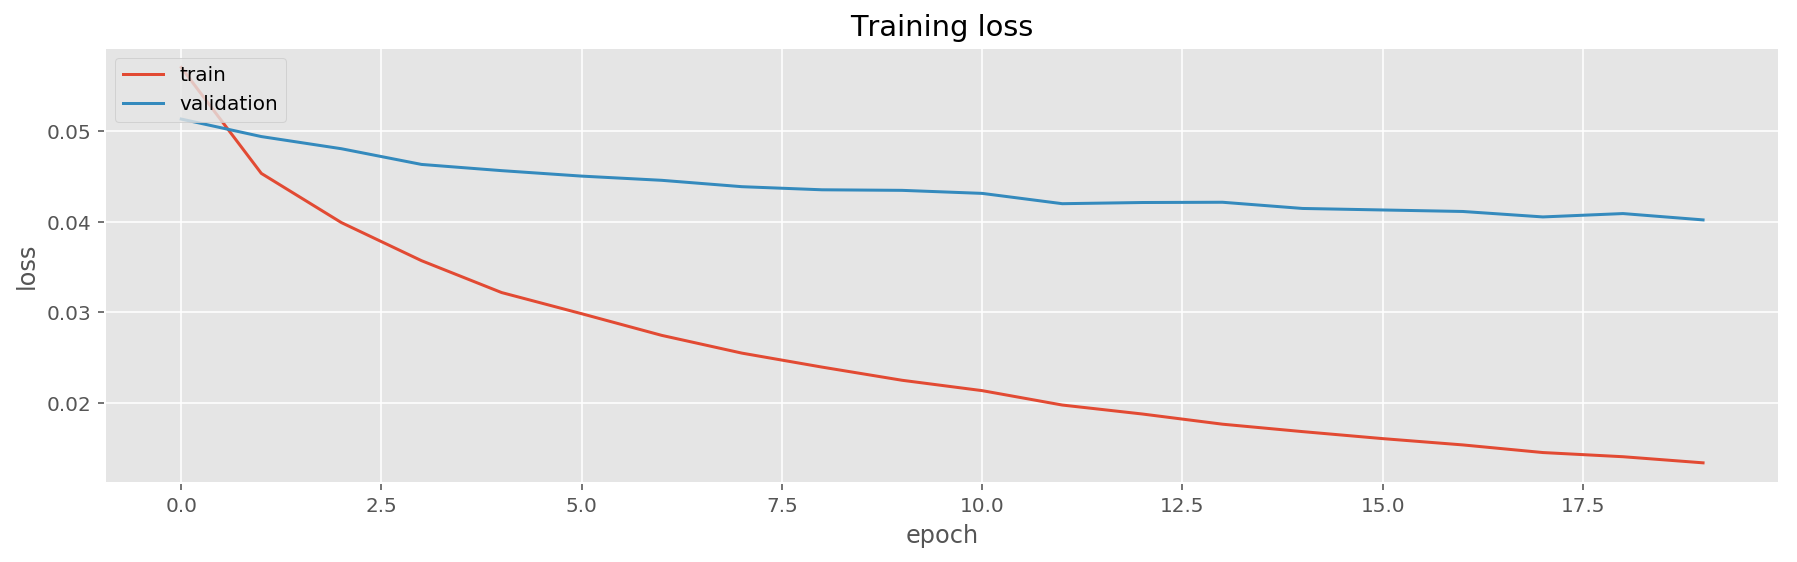

In [11]:
rcParams['figure.figsize'] = 15, 4
plot_train_loss(history)

In [12]:
temporal = baseline()

In [14]:
temporal_final, history1 = train_convnet2D(temporal, train_fl, train_Y, 
                                    val_fl, val_Y, epochs=20,
                                    model_name='temporal_checkpoint_shuffle.hdf5')

Train on 48359 samples, validate on 20726 samples
Epoch 1/20
48359/48359 [==============================] - 86s 2ms/step - loss: 0.0560 - val_loss: 0.0478

Epoch 00001: val_loss improved from inf to 0.04779, saving model to temporal_checkpoint_shuffle.hdf5
Epoch 2/20
48359/48359 [==============================] - 85s 2ms/step - loss: 0.0468 - val_loss: 0.0420

Epoch 00002: val_loss improved from 0.04779 to 0.04201, saving model to temporal_checkpoint_shuffle.hdf5
Epoch 3/20
48359/48359 [==============================] - 85s 2ms/step - loss: 0.0425 - val_loss: 0.0402

Epoch 00003: val_loss improved from 0.04201 to 0.04022, saving model to temporal_checkpoint_shuffle.hdf5
Epoch 4/20
48359/48359 [==============================] - 85s 2ms/step - loss: 0.0391 - val_loss: 0.0382

Epoch 00004: val_loss improved from 0.04022 to 0.03818, saving model to temporal_checkpoint_shuffle.hdf5
Epoch 5/20
48359/48359 [==============================] - 85s 2ms/step - loss: 0.0367 - val_loss: 0.0373

Epoc

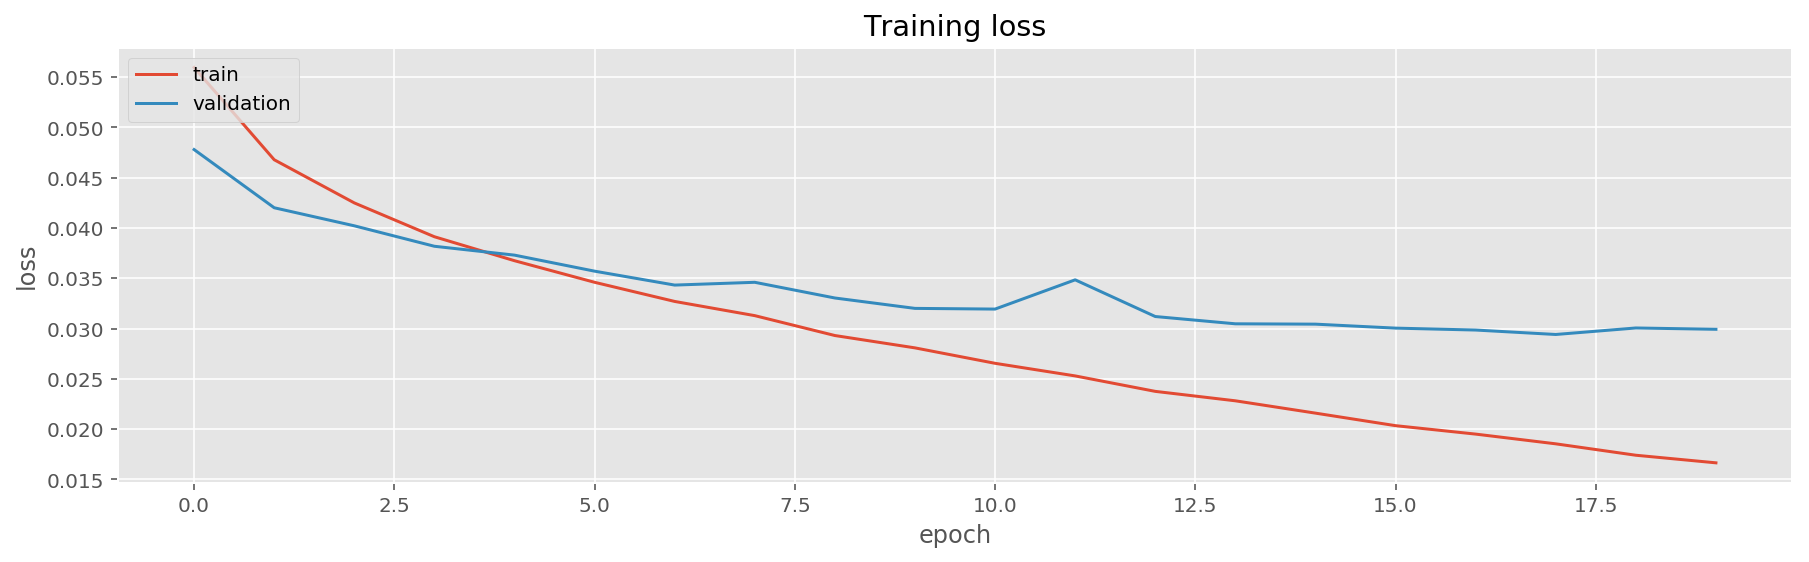

In [15]:
rcParams['figure.figsize'] = 15, 4
plot_train_loss(history1)

### Notes:
    - Images overfit more compared to flows

### Training step 2 - Finetuning models - Not particulary necessary when a good shuffle is done

In [16]:
# Delete variables of the initial training
del train_im, train_fl, train_Y, val_im, val_fl, val_Y 
# Load step2 data
train_im2 = np.load('shuffle_dataset/train_im2.npy')
train_fl2 = np.load('shuffle_dataset/train_fl2.npy')
train_Y2 = np.load('shuffle_dataset/train_Y2.npy')

# Generate a test set of 20% on the training2 partition
train_im2, train_fl2, train_Y2, test_im, test_fl, test_Y = shuffle_data2(train_im2, train_fl2, train_Y2, proportion = 0.8)

100%|██████████| 69086/69086 [00:54<00:00, 1270.79it/s]


### Test both model checkpoints with the test set

In [17]:
# Open models
spatial = load_model('spatial_checkpoint_shuffle.hdf5')
temporal = load_model('temporal_checkpoint_shuffle.hdf5')

In [18]:
spatial.evaluate(test_im, test_Y)

13818/13818 [==============================] - 7s 515us/step


0.04294307046565975

In [19]:
temporal.evaluate(test_fl, test_Y)

13818/13818 [==============================] - 7s 517us/step


0.029921642188260482

### Conclusions:
    - Temporal model outperformed the spatial model.
    - Apparently there is a bis overfit on the spatial model.

### Finetuning spatial and temporal models

In [22]:
# Generate validation partition on the rest of 30%
train_im2, train_fl2, train_Y2, val_im2, val_fl2, val_Y2 = shuffle_data2(train_im2, train_fl2, train_Y2, proportion = 0.70)

100%|██████████| 55268/55268 [00:32<00:00, 1697.77it/s]


In [23]:
# Lowering learning rate and compiling + Train only for 10 epochs to avoid overfitting
adam = Adam(lr=0.5e-4)
spatial.compile(optimizer=adam, loss='mse') 

In [25]:
spatial_fine, history4 = train_convnet2D(spatial, train_im2, train_Y2, 
                                         val_im2, val_Y2, epochs=5,
                                         model_name='spatial_checkpoint_shuffle_fine.hdf5')

Train on 38687 samples, validate on 16581 samples
Epoch 1/5
38687/38687 [==============================] - 68s 2ms/step - loss: 0.0155 - val_loss: 0.0334

Epoch 00001: val_loss improved from inf to 0.03344, saving model to spatial_checkpoint_shuffle_fine.hdf5
Epoch 2/5
38687/38687 [==============================] - 68s 2ms/step - loss: 0.0147 - val_loss: 0.0336

Epoch 00002: val_loss did not improve from 0.03344
Epoch 3/5
38687/38687 [==============================] - 68s 2ms/step - loss: 0.0138 - val_loss: 0.0337

Epoch 00003: val_loss did not improve from 0.03344
Epoch 4/5
34200/38687 [=========================>....] - ETA: 6s - loss: 0.0132

KeyboardInterrupt: 

In [26]:
# Lowering learning rate and compiling
adam = Adam(lr=0.5e-4)
temporal.compile(optimizer=adam, loss='mse') 

In [27]:
temporal_fine, history1 = train_convnet2D(temporal, train_fl2, train_Y2, 
                                    val_fl2, val_Y2, epochs=12,
                                    model_name='temporal_checkpoint_shuffle_fine.hdf5')

Train on 38687 samples, validate on 16581 samples
Epoch 1/12
38687/38687 [==============================] - 69s 2ms/step - loss: 0.0304 - val_loss: 0.0272

Epoch 00001: val_loss improved from inf to 0.02723, saving model to temporal_checkpoint_shuffle_fine.hdf5
Epoch 2/12
38687/38687 [==============================] - 68s 2ms/step - loss: 0.0260 - val_loss: 0.0267

Epoch 00002: val_loss improved from 0.02723 to 0.02671, saving model to temporal_checkpoint_shuffle_fine.hdf5
Epoch 3/12
38687/38687 [==============================] - 68s 2ms/step - loss: 0.0239 - val_loss: 0.0265

Epoch 00003: val_loss improved from 0.02671 to 0.02655, saving model to temporal_checkpoint_shuffle_fine.hdf5
Epoch 4/12
38687/38687 [==============================] - 68s 2ms/step - loss: 0.0220 - val_loss: 0.0265

Epoch 00004: val_loss improved from 0.02655 to 0.02646, saving model to temporal_checkpoint_shuffle_fine.hdf5
Epoch 5/12
38687/38687 [==============================] - 68s 2ms/step - loss: 0.0206 - va

### Checkpoint last finetuned models - You have to beat these results!

In [28]:
# Open models
spatial = load_model('spatial_checkpoint_shuffle_fine.hdf5')
temporal = load_model('temporal_checkpoint_shuffle_fine.hdf5')

In [29]:
spatial.evaluate(test_im, test_Y)

13818/13818 [==============================] - 7s 474us/step


0.03316046628561305

In [30]:
temporal.evaluate(test_fl, test_Y)

13818/13818 [==============================] - 11s 791us/step


0.025416624378739174

### Conclusions:
    - Both models improved by doing the finetuning. The spatial model gained more than the temporal.
    - Temporal model outperform the spatial model

## Two-streams model

In [33]:
train_list = [train_im2, train_fl2]  # train_Y2
val_list = [val_im2, val_fl2] # val_Y2
test_lists = [test_im, test_fl] #test_Y

# Indexes
# train = 38687
# validation = 16581
#del train_im2, train_fl2, val_im2, val_fl2

NameError: name 'train_im2' is not defined

In [45]:
np.save('shuffle_dataset/train_list.npy', train_list)
np.save('shuffle_dataset/val_list.npy', val_list)
np.save('shuffle_dataset/test_list.npy', test_lists)
np.save('shuffle_dataset/train_Y_list.npy', train_Y2)
np.save('shuffle_dataset/val_Y_list.npy', val_Y2)
np.save('shuffle_dataset/test_Y_list.npy', test_Y)


In [43]:
# Saving second partitions
#np.save('shuffle_dataset/train_im2_tr2.npy', train_im2)
#np.save('shuffle_dataset/train_fl2_tr2.npy', train_fl2)
#np.save('shuffle_dataset/train_Y2_tr2.npy', train_Y2)

#np.save('shuffle_dataset/val_im2_tr2.npy', val_im2)
#np.save('shuffle_dataset/val_fl2_tr2.npy', val_fl2)
#np.save('shuffle_dataset/val_Y2_tr2.npy', val_Y2)

#np.save('shuffle_dataset/test_im_tr2.npy', test_im)
#np.save('shuffle_dataset/test_fl_tr2.npy', test_fl)
#np.save('shuffle_dataset/test_Y_tr2.npy', test_Y)


### Create a Two-streams Network

In [37]:
def two_streams1(spatial, temporal, method_add=True):
    
    if method_add == True:
        mergedOut = Add()([spatial.output, temporal.output])
    else:
        mergedOut = Concatenate()([spatial.output, temporal.output])
    
    mergedOut = Dropout(.5)(mergedOut)

    mergedOut = Dense(100, activation='relu')(mergedOut)

    mergedOut = Dense(50, activation='relu')(mergedOut)

    mergedOut = Dense(10, activation='relu')(mergedOut)

    mergedOut = Dense(1, activation='linear')(mergedOut)
    
    return Model([spatial.input, temporal.input], mergedOut)

In [34]:
spatial2 = load_model('spatial_checkpoint_shuffle_fine.hdf5')
temporal2 = load_model('temporal_checkpoint_shuffle_fine.hdf5')

In [35]:
# pop last layers
spatial_pop = Model(spatial2.inputs, spatial2.layers[-5].output)
temporal_pop = Model(temporal2.inputs, temporal2.layers[-5].output)

In [38]:
two_st = two_streams1(spatial_pop, temporal_pop, method_add=True)

In [39]:
# Using a lower learning rate for finetuning!!! We spect the weights are close to the desired solution
#0.0001
adam = Adam(lr=0.5e-4)
two_st.compile(optimizer=adam, loss='mse') 

In [71]:
# After epoch 40
adam = Adam(lr=2.5e-5)
two_st.compile(optimizer=adam, loss='mse') 

In [ ]:
final_2streams, history_streams = train_two_streams(two_st, train_list, 
                                                    train_Y2, val_list, val_Y2,
                                                    epochs= 10, model_name='2streams_checkpoint_final18.hdf5' )

Train on 38687 samples, validate on 16581 samples
Epoch 1/10
38687/38687 [==============================] - 136s 4ms/step - loss: 0.0102 - val_loss: 0.0190

Epoch 00001: val_loss improved from inf to 0.01903, saving model to 2streams_checkpoint_final18.hdf5
Epoch 2/10
38687/38687 [==============================] - 134s 3ms/step - loss: 0.0099 - val_loss: 0.0182

Epoch 00002: val_loss improved from 0.01903 to 0.01818, saving model to 2streams_checkpoint_final18.hdf5
Epoch 3/10
38687/38687 [==============================] - 134s 3ms/step - loss: 0.0098 - val_loss: 0.0189

Epoch 00003: val_loss did not improve from 0.01818
Epoch 4/10
38600/38687 [============================>.] - ETA: 0s - loss: 0.0097

### Apparently a very low learning rate slow the convergency - 40 epochs minimum - after the 40 lower by 0.5 the learning rate

In [53]:
streams = load_model('2streams_checkpoint_final20.hdf5')

In [54]:
streams.evaluate(test_lists, test_Y)

13818/13818 [==============================] - 18s 1ms/step


0.018190024653415956

In [55]:
preds_two = streams.predict(test_lists)

## Ploting predictions

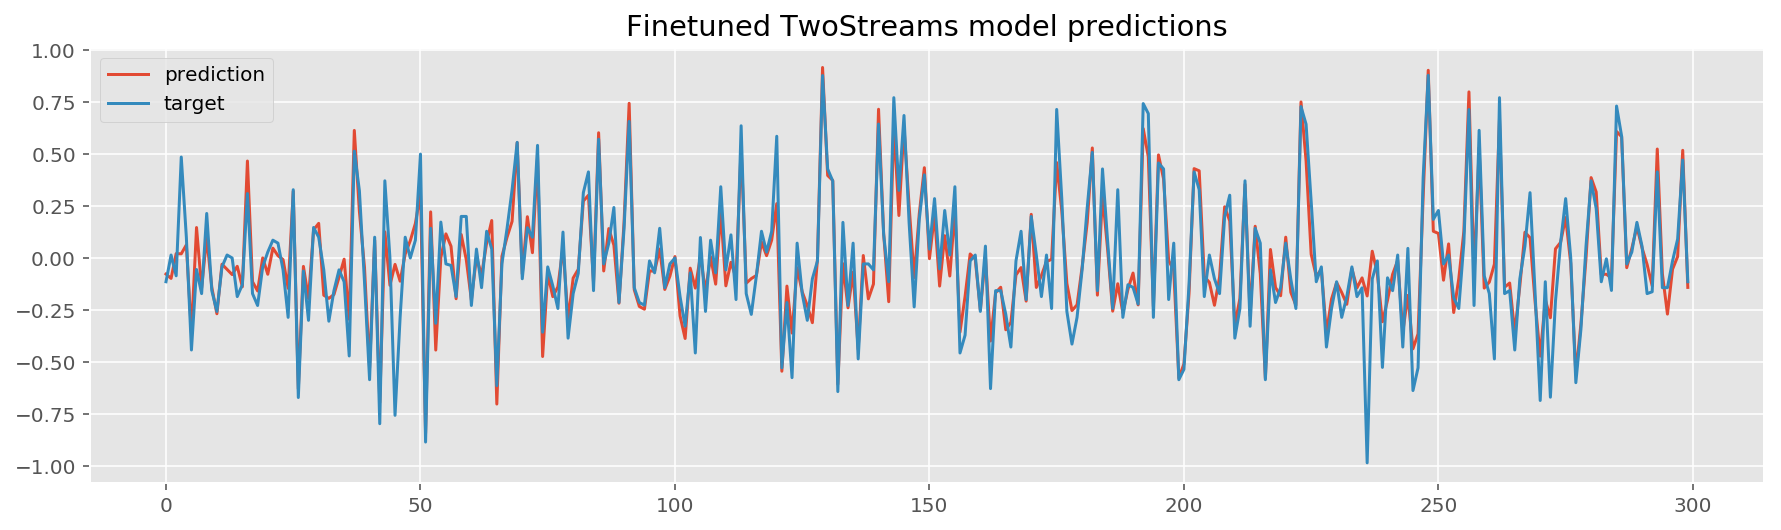

In [58]:
plt.plot(np.array(preds_two[200:500]).reshape(-1), label='prediction')
plt.plot(test_Y[200:500], label='target')
plt.title('Finetuned TwoStreams model predictions')
plt.legend()

In [61]:
np.shape(test_lists[0])

(13818, 160, 320, 3)

In [63]:
im = test_lists[0]

In [66]:
pred_sp = spatial.predict(np.array(im))

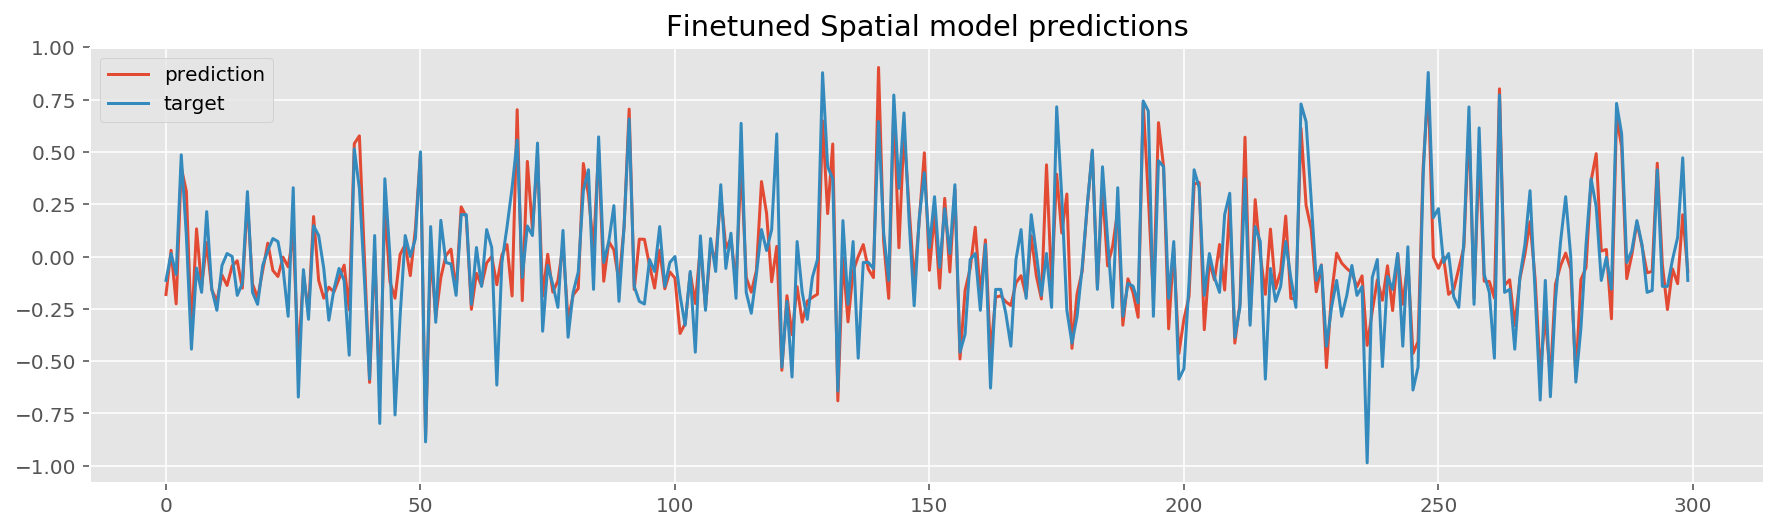

In [68]:
plt.plot(np.array(pred_sp[200:500]).reshape(-1), label='prediction')
plt.plot(test_Y[200:500], label='target')
plt.title('Finetuned Spatial model predictions')
plt.legend()

In [69]:
pred_tm = temporal.predict(np.array(test_lists[1]))

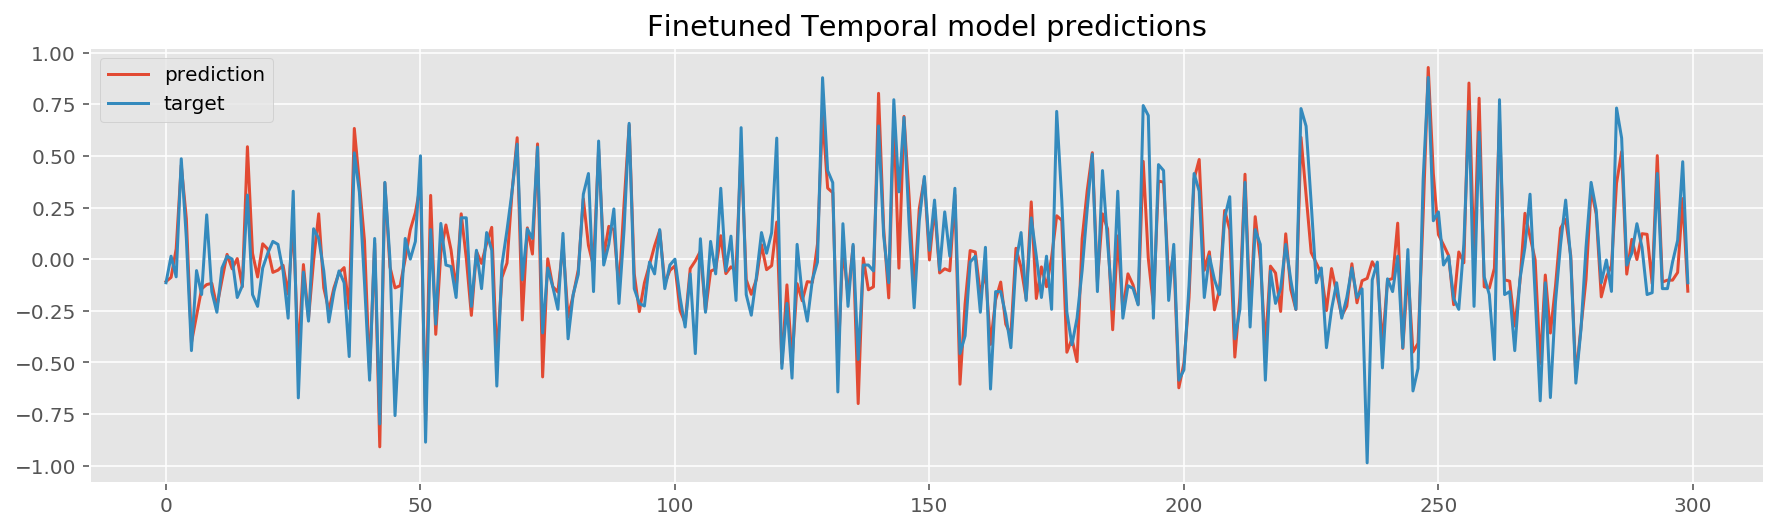

In [70]:
plt.plot(np.array(pred_tm[200:500]).reshape(-1), label='prediction')
plt.plot(test_Y[200:500], label='target')
plt.title('Finetuned Temporal model predictions')
plt.legend()

### Conclusions:
    As all validation and test accuracy are very similar, this means I can automatize the training for 100 epochs with snapshot and early stopping.
    The two-streams model outperforms all other models. 

In [ ]:
#streams = load_model('2streams_checkpoint_final20.hdf5')
#spatial2 = load_model('spatial_checkpoint_shuffle_fine.hdf5')
#temporal2 = load_model('temporal_checkpoint_shuffle_fine.hdf5')